# Memory Performance Prediction using Functional Connectivity in Human Connectome Project (HCP) Dataset

### **Abstract**
Working memory refers to the ability of individuals to temporarily hold and manipulate information in the mind, and constitutes a crucial role in daily functioning (Repovs and Baddeley, 2006). Previous research has characterized working memory as a multicomponent system that correlates with multiple distinct functional connectivity patterns, including activity and interactions between the default mode network (DMN) and frontoparietal network (FPN; Murphy et al., 2020). These studies have used a variety of tasks to study WM, but one popular paradigm is the n-back task. While an understanding of the neural mechanisms underpinning working memory has important clinical implications, predicting individual working memory performance from underlying neural activity has proven challenging thus far. Here, we hypothesized that working memory performance in the 2-back task can be predicted from individuals’ whole-brain functional connectivity patterns. Replicating previous work, we used a connectome-based predictive modeling approach (CPM; Shen et al., 2017; Avery et al., 2020) to predict working memory performance of 339 participants of the Human Connectome Project (HCP). This method leverages the relationship between each individual’s whole-brain functional connectivity pattern and a behavioral measure (here, 2-back accuracy) to construct a linear predictive model of behavior. We found that whole-brain functional connectivity patterns significantly predicted 2-back task performance (positive network: Pearson’s r = 0.26, p = <0.001, MSE = 0.0078; negative network: Pearson’s r = 0.23, p < 0.001, MSE = 0.0081). These results suggest that individual differences in working memory performance can be reliably predicted from task-based functional connectivity patterns, potentially offering a neuroimaging-based biomarker for working memory capacity.

## **Setup**
### Install Dependencies

In [15]:
!pip install nilearn statsmodels matplotlib tqdm Path requests --quiet

### Import Libraries

In [51]:
import os
import sys
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import requests
import tarfile
from pathlib import Path
from tqdm import tqdm

from scipy.stats import pearsonr
from scipy.stats import spearmanr

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.utils import resample
import statsmodels.api as sm

# Necessary for visualization
from nilearn import plotting, datasets

### Ignore Warnings

In [17]:
import warnings
warnings.filterwarnings("ignore")

### Figure settings

In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

## **Basic Parameters**

In [22]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "../data"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

## **Downloading Data**
The rest and task data are shared in different files, but they will unpack into the same directory structure.

Each file is fairly large and will take some time to download. If you are focusing only on rest or task analyses, you may not want to download only that dataset.

We also separately provide some potentially useful behavioral covariate information.

### Utility Functions

In [23]:
DATA_FILES = [
      {"name": "hcp_rest.tgz", "url": "https://osf.io/bqp7m/download"},
      {"name": "hcp_task.tgz", "url": "https://osf.io/s4h8j/download"},
      {"name": "hcp_covariates.tgz", "url": "https://osf.io/x5p4g/download"},
      {"name": "atlas.npz", "url": "https://osf.io/j5kuc/download"}
]

def download_file(
        url,
        file_path,
        progress_bar
    ):
    """Download a file from a given URL to a specified path."""
    try:
        r = requests.get(url, stream=True)
        r.raise_for_status()
        
        with file_path.open("wb") as fid:
            for data in r.iter_content(chunk_size=8192):
                size = fid.write(data)
                progress_bar.update(size)
        
        progress_bar.set_description(f"Downloaded {file_path.name}")
        return True
    except requests.RequestException as e:
        progress_bar.set_description(f"Failed to download {file_path.name}: {e}")
        return False


def extract_tgz(
        file_path,
        extract_path,
        progress_bar
    ):
    """Extract a .tgz file to a specified path."""
    try:
        with tarfile.open(file_path, "r:gz") as tar:
            tar.extractall(path=extract_path)
        progress_bar.set_description(f"Extracted {file_path.name}")
        return True
    except tarfile.TarError as e:
        progress_bar.set_description(f"Failed to extract {file_path.name}: {e}")
        return False


def download_and_extract_data(
        data_dir = Path(HCP_DIR),
        files = DATA_FILES,
        force_download = False
    ):
    """
    Download and extract data files to the specified directory.
    
    Args:
    data_dir (Path): The directory to save and extract the data to. Defaults to Path('../data').
    files (list): List of dictionaries containing file information. Defaults to DATA_FILES.
    force_download (bool): If True, re-download files even if they already exist. Defaults to False.
    
    Returns:
    None
    """
    data_dir.mkdir(parents=True, exist_ok=True)

    total_size = sum(int(requests.head(file_info['url']).headers.get('content-length', 0)) for file_info in files)
    
    with tqdm(total=total_size, unit='iB', unit_scale=True, unit_divisor=1024) as progress_bar:
        for file_info in files:
            file_path = data_dir / file_info['name']
            
            if file_path.is_file() and not force_download:
                print(f"Skipping {file_info['name']}: File already exists")
                # Update progress bar to reflect skipped file
                file_size = file_path.stat().st_size
                progress_bar.update(file_size)
            else:
                progress_bar.set_description(f"Downloading {file_info['name']}")
                if download_file(file_info['url'], file_path, progress_bar):
                    if file_path.suffix == '.tgz':
                        progress_bar.set_description(f"Extracting {file_info['name']}")
                        extract_tgz(file_path, data_dir, progress_bar)

    print("All downloads and extractions completed!")


### Start Downloading

In [24]:
download_and_extract_data()

2.79GiB [00:00, 2.81TiB/s]

Skipping hcp_rest.tgz: File already exists
Skipping hcp_task.tgz: File already exists
Skipping hcp_covariates.tgz: File already exists
Skipping atlas.npz: File already exists
All downloads and extractions completed!


## **Helper Functions**

### Data loading

In [37]:
def get_image_ids(
    name, 
    bold_names
):
    """Get the 1-based image indices for runs in a given experiment.
    
    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
      bold_names (list[str]) : List of each task acquisition
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files
    
    """
    run_ids = [
             i for i, code in enumerate(bold_names, 1) if name.upper() in code
             ]
    if not run_ids:
        raise ValueError(f"Found no data for '{name}'")
    return run_ids


def load_timeseries(
    subject,
    name,
    data_dir,
    bold_names,
    runs=None,
    concat=True,
    remove_mean=True
):
  """Load timeseries data for a single subject.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    data_dir (str) : data directory
    bold_names (list[str]) : List of each task acquisition
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment
  offset = get_image_ids(name, bold_names)[0]

  # Load each run's data
  bold_data = [
               load_single_timeseries(subject,
                                      offset + run,
                                      data_dir,
                                      remove_mean) for run in runs
               ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(
    subject,
    bold_run,
    data_dir,
    remove_mean=True
):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    data_dir (str) : data directory
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = os.path.join(data_dir, "subjects", str(subject), "timeseries")
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(os.path.join(bold_path, bold_file))
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(
    subject, 
    name, 
    bold_names,
    condition, 
    data_dir, 
):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    bold_names (list[str]) : List of each task acquisition
    condition (str) : Name of condition
    data_dir (str) : data directory

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name, bold_names):
    task_key = bold_names[id - 1]
    ev_file = os.path.join(data_dir, "subjects", str(subject), "EVs",
                           task_key, f"{condition}.txt")
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    evs.append(ev)
  return evs

### Task-based Analysis

In [26]:
def condition_frames(run_evs, skip=0):
    """Identify timepoints corresponding to a given condition in each run.
    Args:
        run_evs (list of dicts) : Onset and duration of the event, per run
        skip (int) : Ignore this many frames at the start of each trial, to account
          for hemodynamic lag
    Returns:
        frames_list (list of 1D arrays): Flat arrays of frame indices, per run
    """
    frames_list = []
    for ev in run_evs:
        # Check if the event dictionary is empty
        if not ev:
            continue  # Skip this event and move to the next one

        # Check if 'onset' and 'duration' keys exist
        if 'onset' not in ev or 'duration' not in ev:
            continue  # Skip this event if it doesn't have required keys

        # Determine when trial starts, rounded down
        start = np.floor(ev["onset"] / TR).astype(int)
        # Use trial duration to determine how many frames to include for trial
        duration = np.ceil(ev["duration"] / TR).astype(int)
        # Take the range of frames that correspond to this specific trial
        frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]
        frames_list.append(np.concatenate(frames))
    
    return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev, skip)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    run_frames = run_frames[run_frames < run_data.shape[1]]
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

## **Connectome-based Predictive Modeling**
## Step 1 : Preparing Connectivity and Behavioral Inputs
### Subjects Memory Performance Measurment

In [29]:
wm_behavior = np.genfromtxt(os.path.join(HCP_DIR, "hcp", "behavior", "wm.csv"),
                            delimiter=",",
                            names=True,
                            dtype=None,
                            encoding="utf")
print(wm_behavior[:5])
print(wm_behavior.dtype.names)

[(0, 0, '0BK_BODY', 1., 1., 1.,  705.5,  740.5, 696. )
 (0, 0, '0BK_FACE', 1., 1., 1.,  779.5,  765. , 915. )
 (0, 0, '0BK_PLACE', 1., 1., 1.,  926. ,  993.5, 811.5)
 (0, 0, '0BK_TOOL', 1., 1., 1.,  807.5,  807.5, 807.5)
 (0, 0, '2BK_BODY', 1., 1., 1., 1133. , 1205.5, 732.5)]
('Subject', 'Run', 'ConditionName', 'ACC', 'ACC_NONTARGET', 'ACC_TARGET', 'MEDIAN_RT', 'MEDIAN_RT_NONTARGET', 'MEDIAN_RT_TARGET')


In [31]:
hcp_columns = ['Subject', 'Run', 'ConditionName', 'ACC', 'ACC_NONTARGET', 'ACC_TARGET', 'MEDIAN_RT', 'MEDIAN_RT_NONTARGET', 'MEDIAN_RT_TARGET']
result_columns = ['Subject', '0BK_ACC', '0BK_MEDIAN_RT', '2BK_ACC', '2BK_MEDIAN_RT']

def calculate_single_subject_performance_metrics(df, subject_id):
    subject_data = df[df['Subject'] == subject_id]

    zero_back = subject_data[subject_data['ConditionName'].str.startswith('0BK')]
    two_back = subject_data[subject_data['ConditionName'].str.startswith('2BK')]

    zero_back_acc = zero_back['ACC'].mean() if not zero_back.empty else None
    zero_back_rt = zero_back['MEDIAN_RT'].mean() if not zero_back.empty else None

    two_back_acc = two_back['ACC'].mean() if not two_back.empty else None
    two_back_rt = two_back['MEDIAN_RT'].mean() if not two_back.empty else None

    return pd.DataFrame([[subject_id, zero_back_acc, zero_back_rt, two_back_acc, two_back_rt]], columns=result_columns)

def calculate_memory_performance(df):
    subjects = df['Subject'].unique()
    performance_metrics = []

    for subject_id in subjects:
        subject_metrics = calculate_single_subject_performance_metrics(df, subject_id)
        performance_metrics.append(subject_metrics)

    performance_metrics_df = pd.concat(performance_metrics, ignore_index=True)
    return performance_metrics_df

In [32]:
df = pd.DataFrame(wm_behavior, columns=hcp_columns)

# calculate_single_subject_performance_metrics(df, 15)
memory_performance_metrics = calculate_memory_performance(df)
print(memory_performance_metrics.head(20))

    Subject  0BK_ACC  0BK_MEDIAN_RT   2BK_ACC  2BK_MEDIAN_RT
0         0   1.0000       852.2500  0.921875      1054.4375
1         1   1.0000       529.0625  0.968750       865.5625
2         2   0.9875       584.1250  0.921875       940.5625
3         3   0.9750       731.7500  0.703125       798.0000
4         4   0.6750       852.8125  0.765625       864.0625
5         5   1.0000       699.5000  0.906250       996.0000
6         6   0.9500       697.3750  0.859375      1045.7500
7         7   0.7875       799.8125  0.671875       778.7500
8         8   0.7125      1012.0000  0.875000      1052.1250
9         9   0.6875       907.1875  0.640625       977.0625
10       10   0.7375      1018.3750  0.828125      1040.3750
11       11   0.9375       782.0625  1.000000       904.7500
12       12   1.0000       709.7500  0.875000      1092.2500
13       13   1.0000       883.5000  0.921875      1061.4375
14       14   0.9625       640.1250  0.781250      1019.1250
15       15   0.9250    

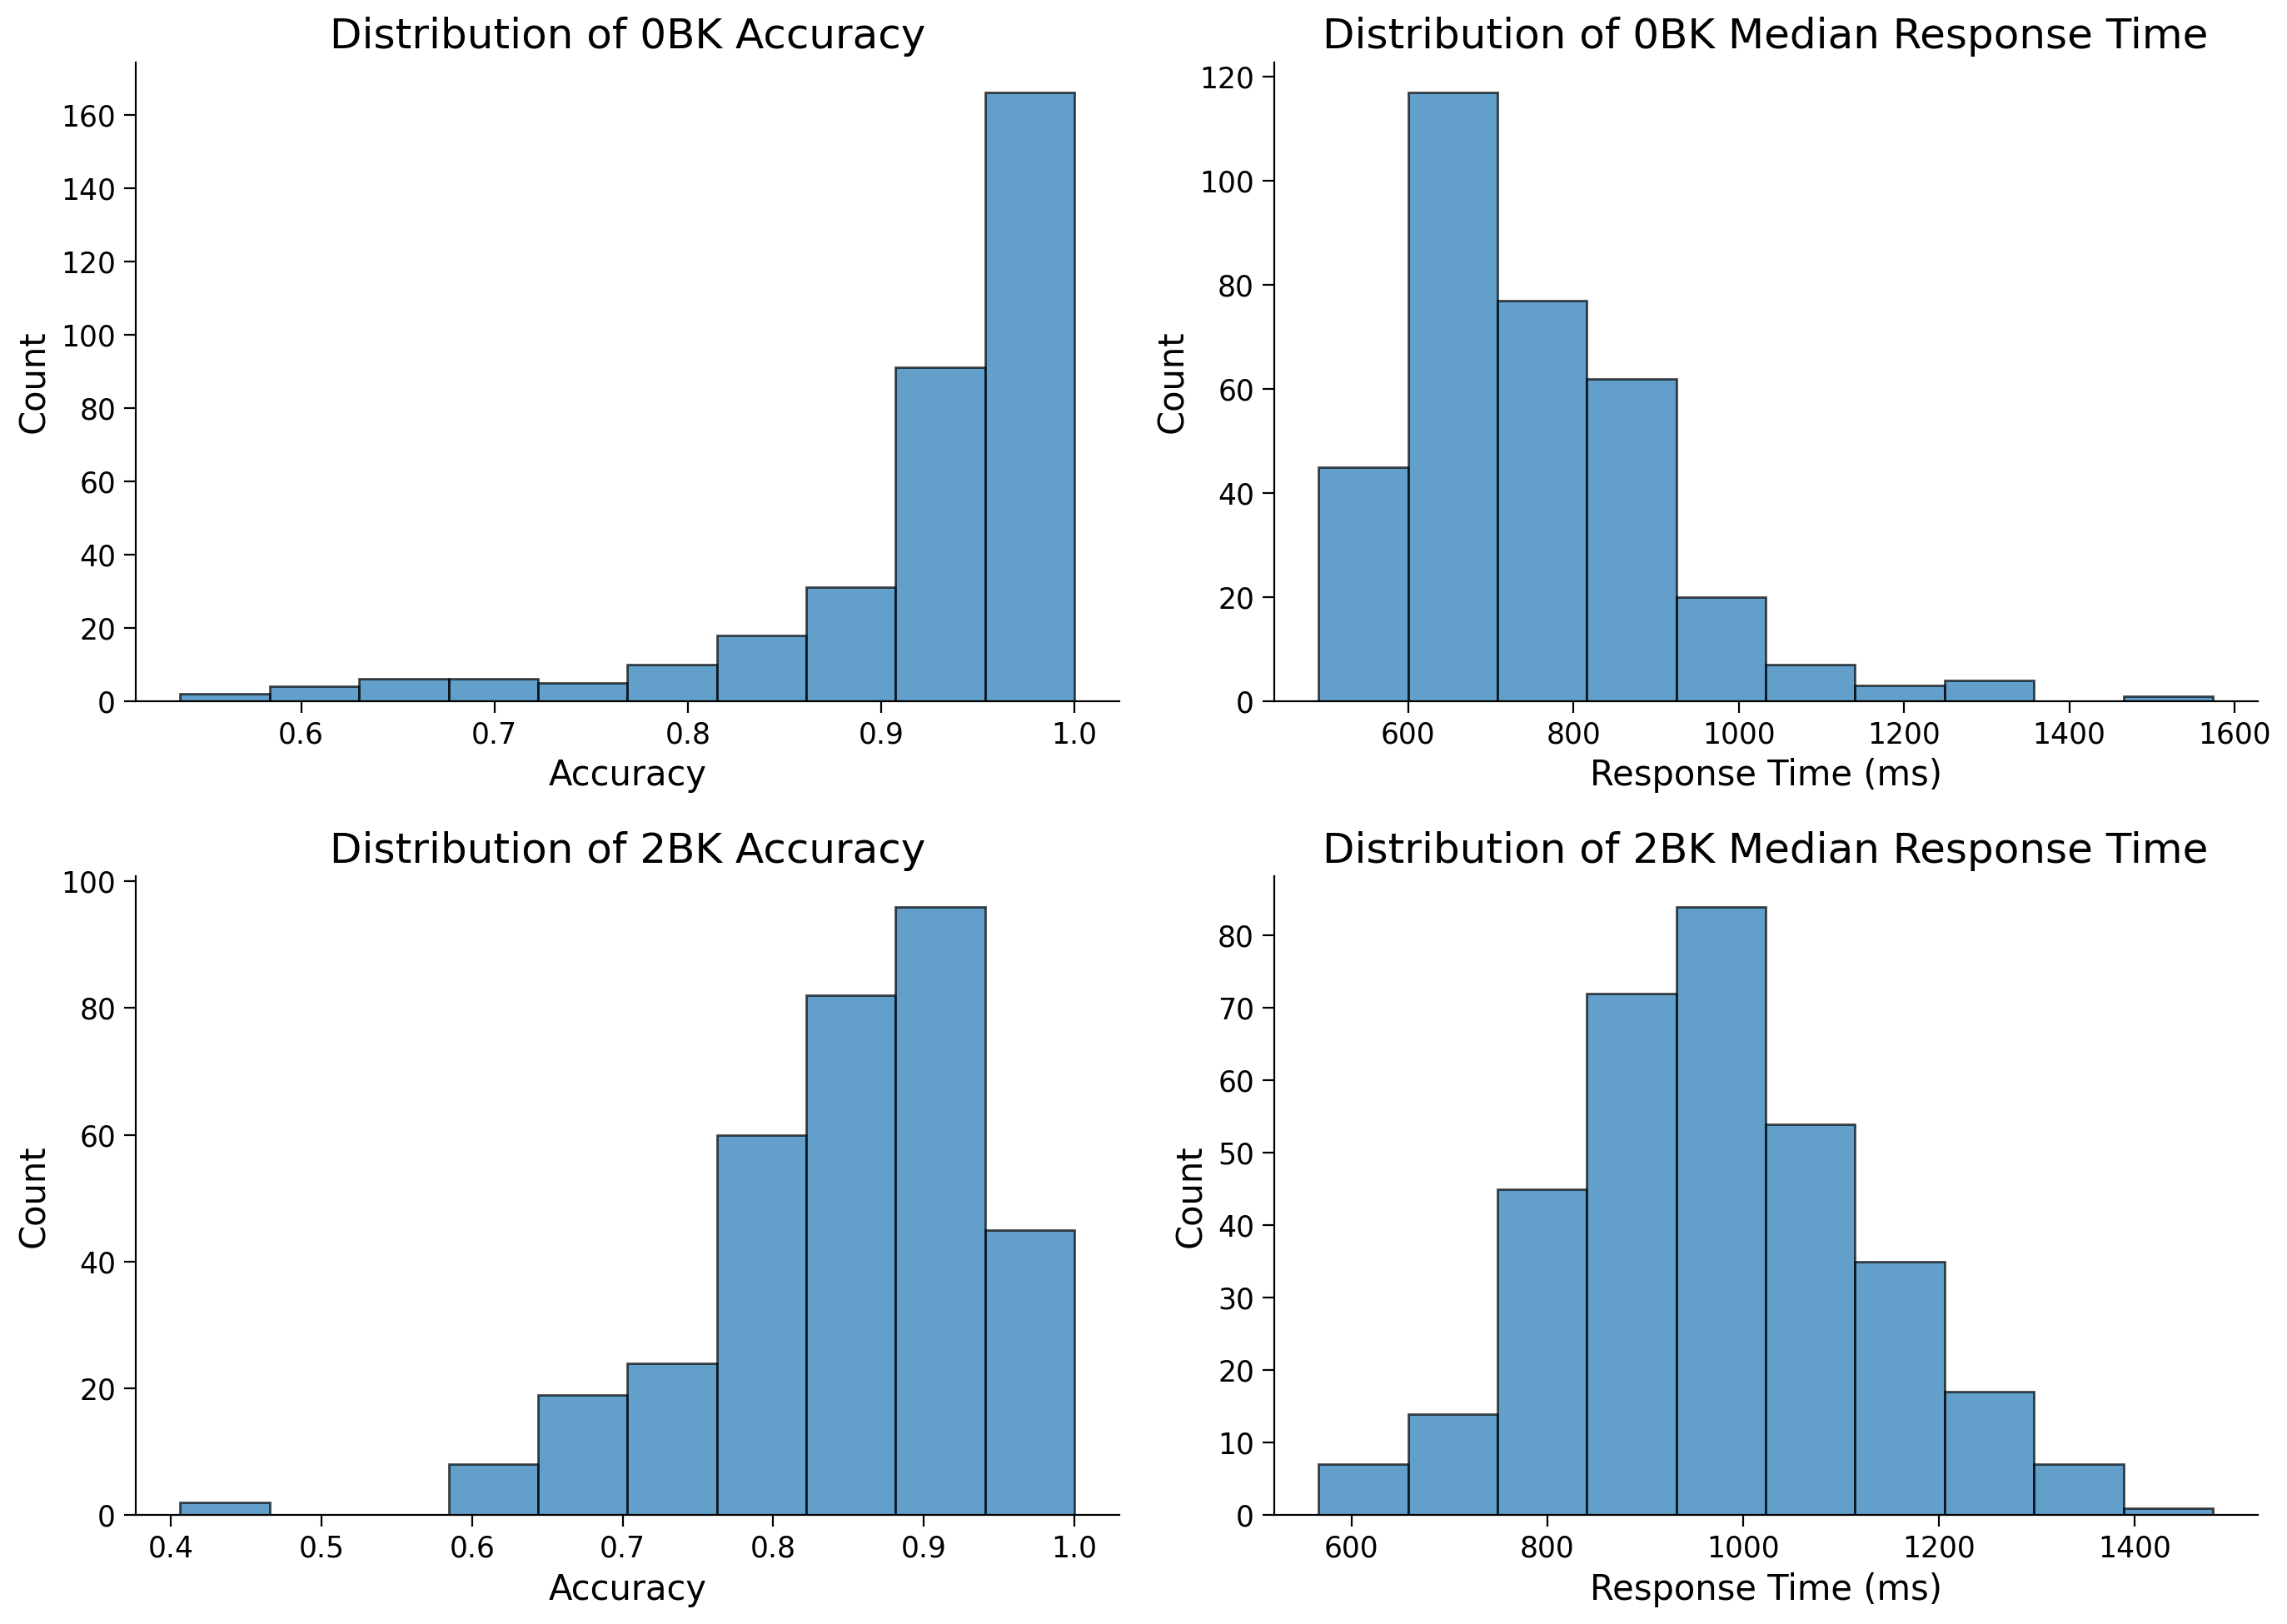

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# Plot 0BK_ACC Histogram
axes[0, 0].hist(memory_performance_metrics['0BK_ACC'].dropna(), bins=10, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of 0BK Accuracy')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_ylabel('Count')

# Plot 0BK_MEDIAN_RT Histogram
axes[0, 1].hist(memory_performance_metrics['0BK_MEDIAN_RT'].dropna(), bins=10, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of 0BK Median Response Time')
axes[0, 1].set_xlabel('Response Time (ms)')
axes[0, 1].set_ylabel('Count')

# Plot 2BK_ACC Histogram
axes[1, 0].hist(memory_performance_metrics['2BK_ACC'].dropna(), bins=10, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Distribution of 2BK Accuracy')
axes[1, 0].set_xlabel('Accuracy')
axes[1, 0].set_ylabel('Count')

# Plot 2BK_MEDIAN_RT Histogram
axes[1, 1].hist(memory_performance_metrics['2BK_MEDIAN_RT'].dropna(), bins=10, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Distribution of 2BK Median Response Time')
axes[1, 1].set_xlabel('Response Time (ms)')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

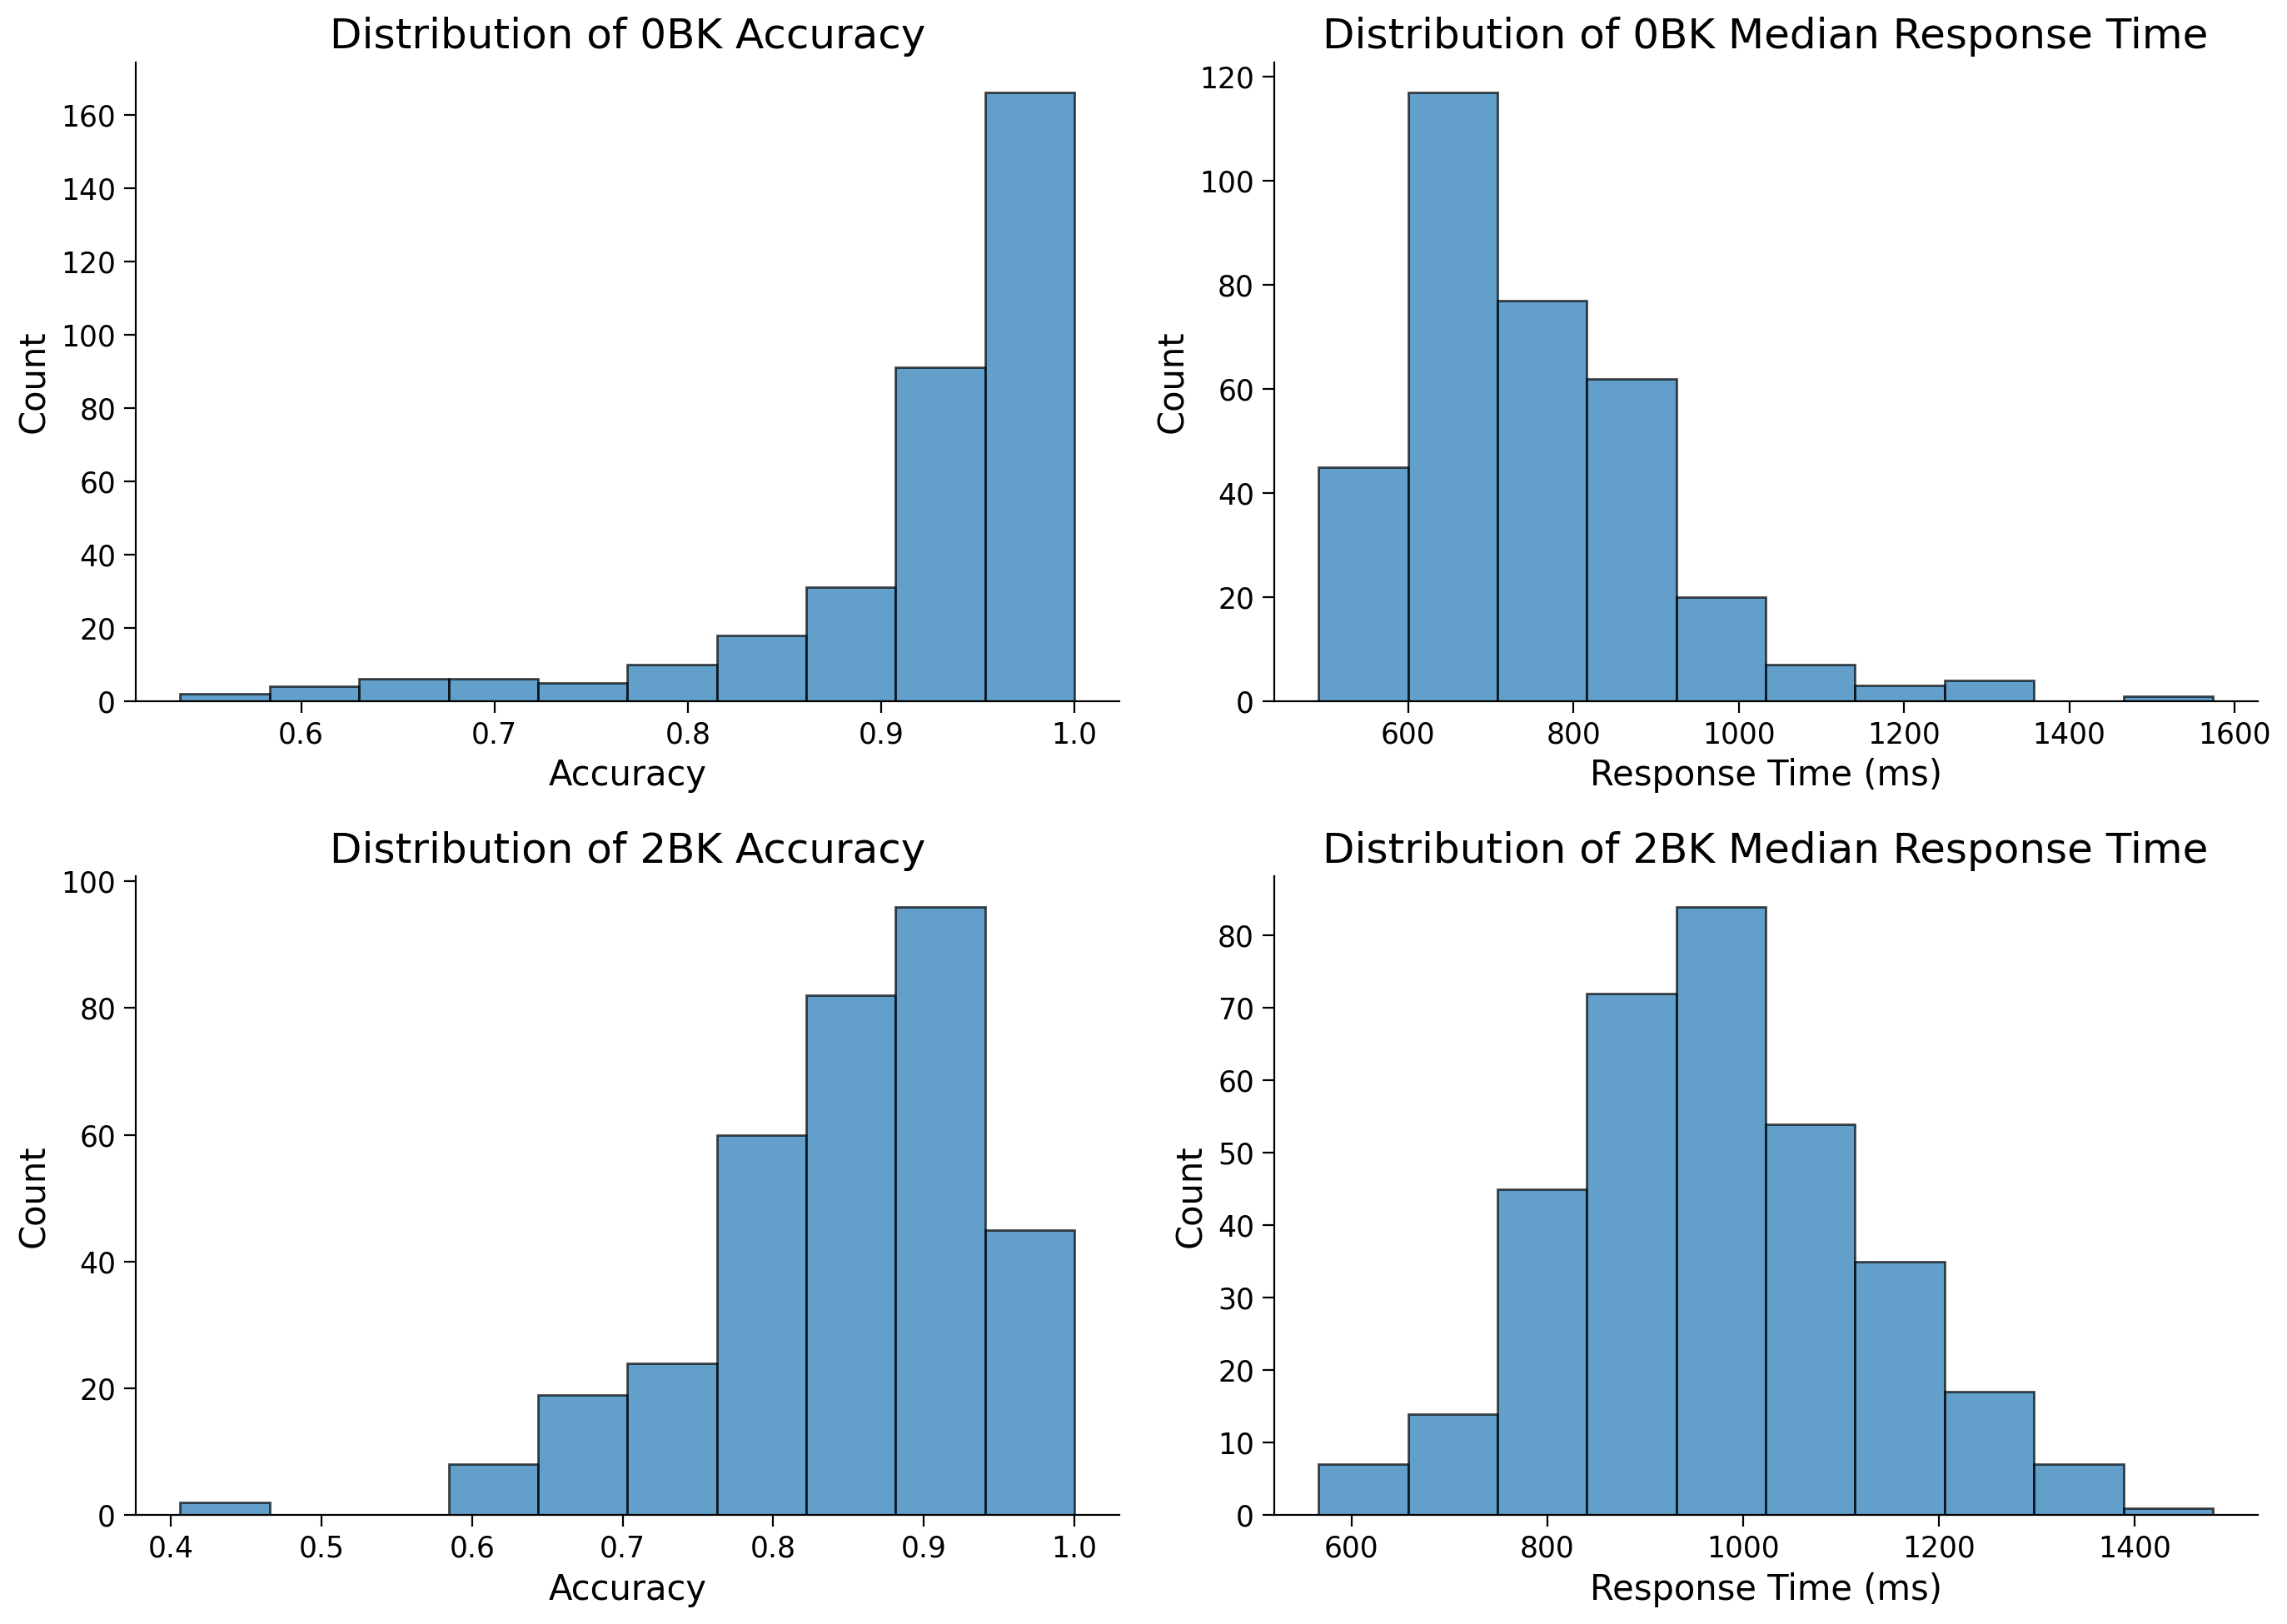

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# Plot 0BK_ACC Histogram
axes[0, 0].hist(memory_performance_metrics['0BK_ACC'].dropna(), bins=10, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of 0BK Accuracy')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_ylabel('Count')

# Plot 0BK_MEDIAN_RT Histogram
axes[0, 1].hist(memory_performance_metrics['0BK_MEDIAN_RT'].dropna(), bins=10, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of 0BK Median Response Time')
axes[0, 1].set_xlabel('Response Time (ms)')
axes[0, 1].set_ylabel('Count')

# Plot 2BK_ACC Histogram
axes[1, 0].hist(memory_performance_metrics['2BK_ACC'].dropna(), bins=10, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Distribution of 2BK Accuracy')
axes[1, 0].set_xlabel('Accuracy')
axes[1, 0].set_ylabel('Count')

# Plot 2BK_MEDIAN_RT Histogram
axes[1, 1].hist(memory_performance_metrics['2BK_MEDIAN_RT'].dropna(), bins=10, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Distribution of 2BK Median Response Time')
axes[1, 1].set_xlabel('Response Time (ms)')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Functional Connectivity Matrices

In [40]:
def calculate_fc(
    timeseries,
    indices
):
    timeseries = timeseries[indices, :]
    correlation_matrix = np.corrcoef(timeseries)
    return correlation_matrix


def plot_connectivity_matrix(matrix, title):
    plt.figure(figsize=(8, 8))
    plt.imshow(matrix, vmin=-1, vmax=1, cmap='coolwarm')
    plt.colorbar()
    plt.title(title)
    plt.show()


def transform_fc_matrices(fc_matrix_list):
    """
    Transform a list of FC matrices into the 3D array format expected by the CPM implementation.
    
    Parameters:
    fc_matrix_list (list): List of 2D numpy arrays, each representing a subject's FC matrix.
    
    Returns:
    numpy.ndarray: 3D array with shape (n_nodes, n_nodes, n_subjects)
    """
    # Check if all matrices have the same shape
    shapes = set(matrix.shape for matrix in fc_matrix_list)
    if len(shapes) != 1:
        raise ValueError("All matrices must have the same shape")
    
    # Get the number of nodes and subjects
    n_nodes = fc_matrix_list[0].shape[0]
    n_subjects = len(fc_matrix_list)
    
    # Create the 3D array
    fc_array_3d = np.stack(fc_matrix_list, axis=2)
    
    print(f"Transformed FC matrices into 3D array with shape: {fc_array_3d.shape}")
    return fc_array_3d

In [41]:
timeseries_task = []
corr_matrices = []
frames_2back = []

for subject in subjects:
    frames_cor = []
    #### Get the LR timeseries for the working memory task
    ####
    timeseries = load_timeseries(
        subject=subject,
        name="wm_lr",
        bold_names=BOLD_NAMES,
        data_dir=HCP_DIR + "/hcp_task"
    )
    # Get the frames for 2-back correct and error trials
    evs_cor = load_evs(
        subject=subject,
        name="wm_lr",
        bold_names=BOLD_NAMES,
        condition="2bk_cor",
        data_dir=HCP_DIR + "/hcp_task"
    )
    evs_err = load_evs(
        subject=subject,
        name="wm_lr",
        bold_names=BOLD_NAMES,
        condition="2bk_err",
        data_dir=HCP_DIR + "/hcp_task"
    )
    
    frames_cor = condition_frames(evs_cor)
    frames_err = condition_frames(evs_err)

    if len(frames_err) > 0:
        frames_2back = sorted(np.concatenate([frames_cor, frames_err], axis=1)[0])
    else:
        frames_2back = sorted(frames_cor[0])
    timeseries_2back_lr = timeseries[:, frames_2back]

    #### Get the RL timeseries for the working memory task
    ####
    timeseries = load_timeseries(
        subject=subject,
        name="wm_rl",
        bold_names=BOLD_NAMES,
        data_dir=HCP_DIR + "/hcp_task"
    )
    # Get the frames for 2-back correct and error trials
    evs_cor = load_evs(
        subject=subject,
        name="wm_rl",
        bold_names=BOLD_NAMES,
        condition="2bk_cor",
        data_dir=HCP_DIR + "/hcp_task"
    )
    evs_err = load_evs(
        subject=subject,
        name="wm_rl",
        bold_names=BOLD_NAMES,
        condition="2bk_err",
        data_dir=HCP_DIR + "/hcp_task"
    )
    
    frames_cor = condition_frames(evs_cor)
    frames_err = condition_frames(evs_err)

    if len(frames_err) > 0:
        frames_2back = sorted(np.concatenate([frames_cor, frames_err], axis=1)[0])
    else:
        frames_2back = sorted(frames_cor[0])
    timeseries_2back_rl = timeseries[:, frames_2back]
    
    # Combine correct and error frames
    timeseries_2back = np.mean([timeseries_2back_lr, timeseries_2back_rl], axis=0)

    #### Compute connectivity matrix and append to list
    ####
    fc = calculate_fc(timeseries_2back, np.arange(0, 360))
    corr_matrices.append(fc)

In [42]:
fc_matrices = transform_fc_matrices(corr_matrices)
print(fc_matrices.shape)
print(memory_performance_metrics.shape)

Transformed FC matrices into 3D array with shape: (360, 360, 339)
(360, 360, 339)
(339, 5)


## Step 2: Connectivity and Behavior Integration

In [44]:
num_subjects = fc_matrices.shape[2]
flattened_connectivity = fc_matrices.reshape(360*360, num_subjects).T
connectivity_df = pd.DataFrame(flattened_connectivity)
connectivity_df['Subject'] = memory_performance_metrics['Subject']

# Merge connectivity features with memory performance metrics using the subject ID
merged_df = pd.merge(memory_performance_metrics, connectivity_df, on='Subject')

# Features (X) are the connectivity features
X = merged_df.drop(columns=['Subject', '0BK_ACC', '0BK_MEDIAN_RT', '2BK_ACC', '2BK_MEDIAN_RT']).values
# Target variable (y) is 0BK_ACC
y = merged_df['2BK_ACC'].values
not_nan_indices = ~np.isnan(y)
X = X[not_nan_indices]
y = y[not_nan_indices]
print(X.shape)
print(y.shape)

(336, 129600)
(336,)


## Step 3: Selecting Most Significant Edges

In [47]:
def select_significant_edges(X, y, p_threshold=0.001):
        num_edges = X.shape[1]
        positive_significant_edges = np.zeros(num_edges, dtype=bool)
        negative_significant_edges = np.zeros(num_edges, dtype=bool)
        
        for edge in range(num_edges):
            #r, p = pearsonr(X[:, edge], y)
            r, p = spearmanr(X[:, edge], y)
            if p < p_threshold:
                fisher_z = np.arctanh(r)
                if fisher_z > 0:
                    positive_significant_edges[edge] = True
                if fisher_z < 0:
                    negative_significant_edges[edge] = True
        
        return positive_significant_edges, negative_significant_edges

In [48]:
positive_significant_edges, negative_significant_edges = select_significant_edges(X, y)

## Step 4: Sum Selected Edge

In [49]:
def create_summary_features(X, significant_edges):
    return X[:, significant_edges].sum(axis=1)

In [50]:
# Create summary features
X_summary_positive = create_summary_features(X, positive_significant_edges)
X_summary_negative = create_summary_features(X, negative_significant_edges)
print(X_summary_positive.shape)
print(X_summary_negative.shape)

(336,)
(336,)


## Step 5: Linear Model Fitting

### **Plotting**

In [55]:
def plot_connectivity_vs_behavior(X_summary, y, model=None):
    """
    Plot connectivity summary features against behavioral measure and model line.
    
    Parameters:
    X_summary (numpy array): Summary feature matrix.
    y (numpy array): Target vector.
    model: Trained linear regression model (optional).
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(X_summary, y, color='blue', label='Observed data')
    
    if model is not None:
        # Predict using the model
        y_pred = model.predict(X_summary)
        plt.plot(X_summary, y_pred, color='red', linewidth=2, label='Model prediction')
        slope = model.coef_[0]
        intercept = model.intercept_
        
        # Display model parameters on the plot
        plt.text(0.05, 0.95, f'Slope: {slope:.4f}\nIntercept: {intercept:.4f}', 
                 transform=plt.gca().transAxes, fontsize=12,
                 verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
    
    plt.xlabel('Connectivity Summary Features')
    plt.ylabel('Behavioral Measure')
    plt.title('Connectivity Summary Features vs. Behavioral Measure')
    plt.legend()
    plt.grid(True)
    plt.show()

### **Training and Fitting**

In [56]:
def train_linear_regression(X_train, y_train):
    """
    Trains a linear regression model.

    Parameters:
    X_train (numpy array): Training feature matrix.
    y_train (numpy array): Training target vector.

    Returns:
    model: Trained linear regression model.
    """
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

def predict(model, X_test):
    """
    Makes predictions using the trained linear regression model.

    Parameters:
    model: Trained linear regression model.
    X_test (numpy array): Testing feature matrix.

    Returns:
    y_pred (numpy array): Predicted target vector.
    """
    y_pred = model.predict(X_test)
    return y_pred

### **Evaluation Methods**

In [57]:
def split_data(X, y, test_size=0.2, random_state=42):
    """
    Splits the data into training and testing sets.

    Parameters:
    X (numpy array): Feature matrix.
    y (numpy array): Target vector.
    test_size (float): Proportion of the dataset to include in the test split.
    random_state (int): Seed used by the random number generator.

    Returns:
    X_train, X_test, y_train, y_test: Split data.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

def evaluate_model_mse(y_test, y_pred):
    """
    Evaluates the model performance.

    Parameters:
    y_test (numpy array): True target vector.
    y_pred (numpy array): Predicted target vector.

    Returns:
    mse (float): Mean Squared Error.
    r2 (float): R-squared value.
    """
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

def compute_p_values(X, y):
    """
    Compute p-values for the coefficients of a linear regression model.
    
    Parameters:
    X (numpy array): Feature matrix.
    y (numpy array): Target vector.
    
    Returns:
    p_values (numpy array): p-values for the coefficients.
    """
    # Add a constant (intercept) to the model
    X = sm.add_constant(X)
    
    # Fit the model
    model = sm.OLS(y, X).fit()
    
    # Get p-values
    p_values = model.pvalues
    return p_values

def kfold_cross_validation(X, y, k=10, plotting=True):
    """
    Performs 10-fold cross-validation for linear regression.

    Parameters:
    X (numpy array): Feature matrix.
    y (numpy array): Target vector.
    k (int): Number of folds. Default is 10.

    Returns:
    float: Mean R score across folds.
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    r_scores = []
    mse_scores = []
    p_scores = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = train_linear_regression(X_train, y_train)
        y_pred = predict(model, X_test)
        if plotting:
            plot_connectivity_vs_behavior(X_test.reshape(-1, 1), y_test, model)
        
        mse, r2 = evaluate_model_mse(y_test, y_pred)
        p_value = compute_p_values(X_train, y_train)
        r = np.sqrt(r2) if r2 > 0 else 0
        r_scores.append(r)
        mse_scores.append(mse)
        p_scores.append(p_value[1:])
    
    mean_r = np.mean(r_scores)
    mean_mse = np.mean(mse_scores)
    mean_p_values = np.mean(np.vstack(p_scores), axis=0)
    return mean_r, mean_mse, mean_p_values

def bootstrapping_validation(X, y, n_iterations=500, test_size=0.2, plotting=True):
    """
    Performs bootstrapped linear regression and evaluates the model performance.

    Parameters:
    X (numpy array): Feature matrix.
    y (numpy array): Target vector.
    n_iterations (int): Number of bootstrap iterations.
    test_size (float): Proportion of the dataset to include in the test split.

    Returns:
    float: Mean R score across folds.
    """
    n_size = int(len(X) * (1 - test_size))
    indices = np.arange(len(X))
    r_scores = []
    mse_scores = []
    p_scores = []
    
    for i in range(n_iterations):
        train_indices = resample(indices, n_samples=n_size, replace=True)
        test_indices = np.setdiff1d(indices, train_indices)

        X_train, y_train = X[train_indices], y[train_indices]
        X_test, y_test = X[test_indices], y[test_indices]
        
        model = train_linear_regression(X_train, y_train)
        y_pred = predict(model, X_test)
        if plotting:
            plot_connectivity_vs_behavior(X_test.reshape(-1, 1), y_test, model)
        
        mse, r2 = evaluate_model_mse(y_test, y_pred)
        p_value = compute_p_values(X_train, y_train)
        r = np.sqrt(r2) if r2 > 0 else 0
        r_scores.append(r)
        mse_scores.append(mse)
        p_scores.append(p_value[1:])
    
    mean_r = np.mean(r_scores)
    mean_mse = np.mean(mse_scores)
    mean_p_values = np.mean(np.vstack(p_scores), axis=0)
    return mean_r, mean_mse, mean_p_values

## Step 6: CPM Evaluation

In [58]:
positive_kfold_result = kfold_cross_validation(X_summary_positive.reshape(-1, 1), y, plotting=False)
print(f"KFOLD Mean R score across 10 folds: {positive_kfold_result[0]:.4f}")
print(f"KFOLD Mean p-values across 10 folds: {positive_kfold_result[2][0]:.4E}")
print(f"KFOLD Mean MSE score across 10 folds: {positive_kfold_result[1]:.4f}")

positive_bootstrap_result = bootstrapping_validation(X_summary_positive.reshape(-1, 1), y, plotting=False)
print(f"BOOTSTRAP Mean R score across 500 run: {positive_bootstrap_result[0]:.4f}")
print(f"BOOTSTRAP Mean p-values across 500 run: {positive_bootstrap_result[2][0]:.4E}")
print(f"BOOTSTRAP Mean MSE score across 500 run: {positive_bootstrap_result[1]:.4f}")

KFOLD Mean R score across 10 folds: 0.2426
KFOLD Mean p-values across 10 folds: 2.4854E-10
KFOLD Mean MSE score across 10 folds: 0.0078
BOOTSTRAP Mean R score across 500 run: 0.3133
BOOTSTRAP Mean p-values across 500 run: 9.0536E-06
BOOTSTRAP Mean MSE score across 500 run: 0.0079


In [59]:
negative_kfold_result = kfold_cross_validation(X_summary_negative.reshape(-1, 1), y, plotting=False)
print(f"KFOLD Mean R score across 10 folds: {negative_kfold_result[0]:.4f}")
print(f"KFOLD Mean p-values across 10 folds: {negative_kfold_result[2][0]:.4E}")
print(f"KFOLD Mean MSE score across 10 folds: {negative_kfold_result[1]:.4f}")

negative_bootstrap_result = bootstrapping_validation(X_summary_negative.reshape(-1, 1), y, plotting=False)
print(f"BOOTSTRAP Mean R score across 500 run: {negative_bootstrap_result[0]:.4f}")
print(f"BOOTSTRAP Mean p-values across 500 run: {negative_bootstrap_result[2][0]:.4E}")
print(f"BOOTSTRAP Mean MSE score across 500 run: {negative_bootstrap_result[1]:.4f}")

KFOLD Mean R score across 10 folds: 0.2755
KFOLD Mean p-values across 10 folds: 1.5617E-10
KFOLD Mean MSE score across 10 folds: 0.0077
BOOTSTRAP Mean R score across 500 run: 0.3385
BOOTSTRAP Mean p-values across 500 run: 1.5176E-06
BOOTSTRAP Mean MSE score across 500 run: 0.0078


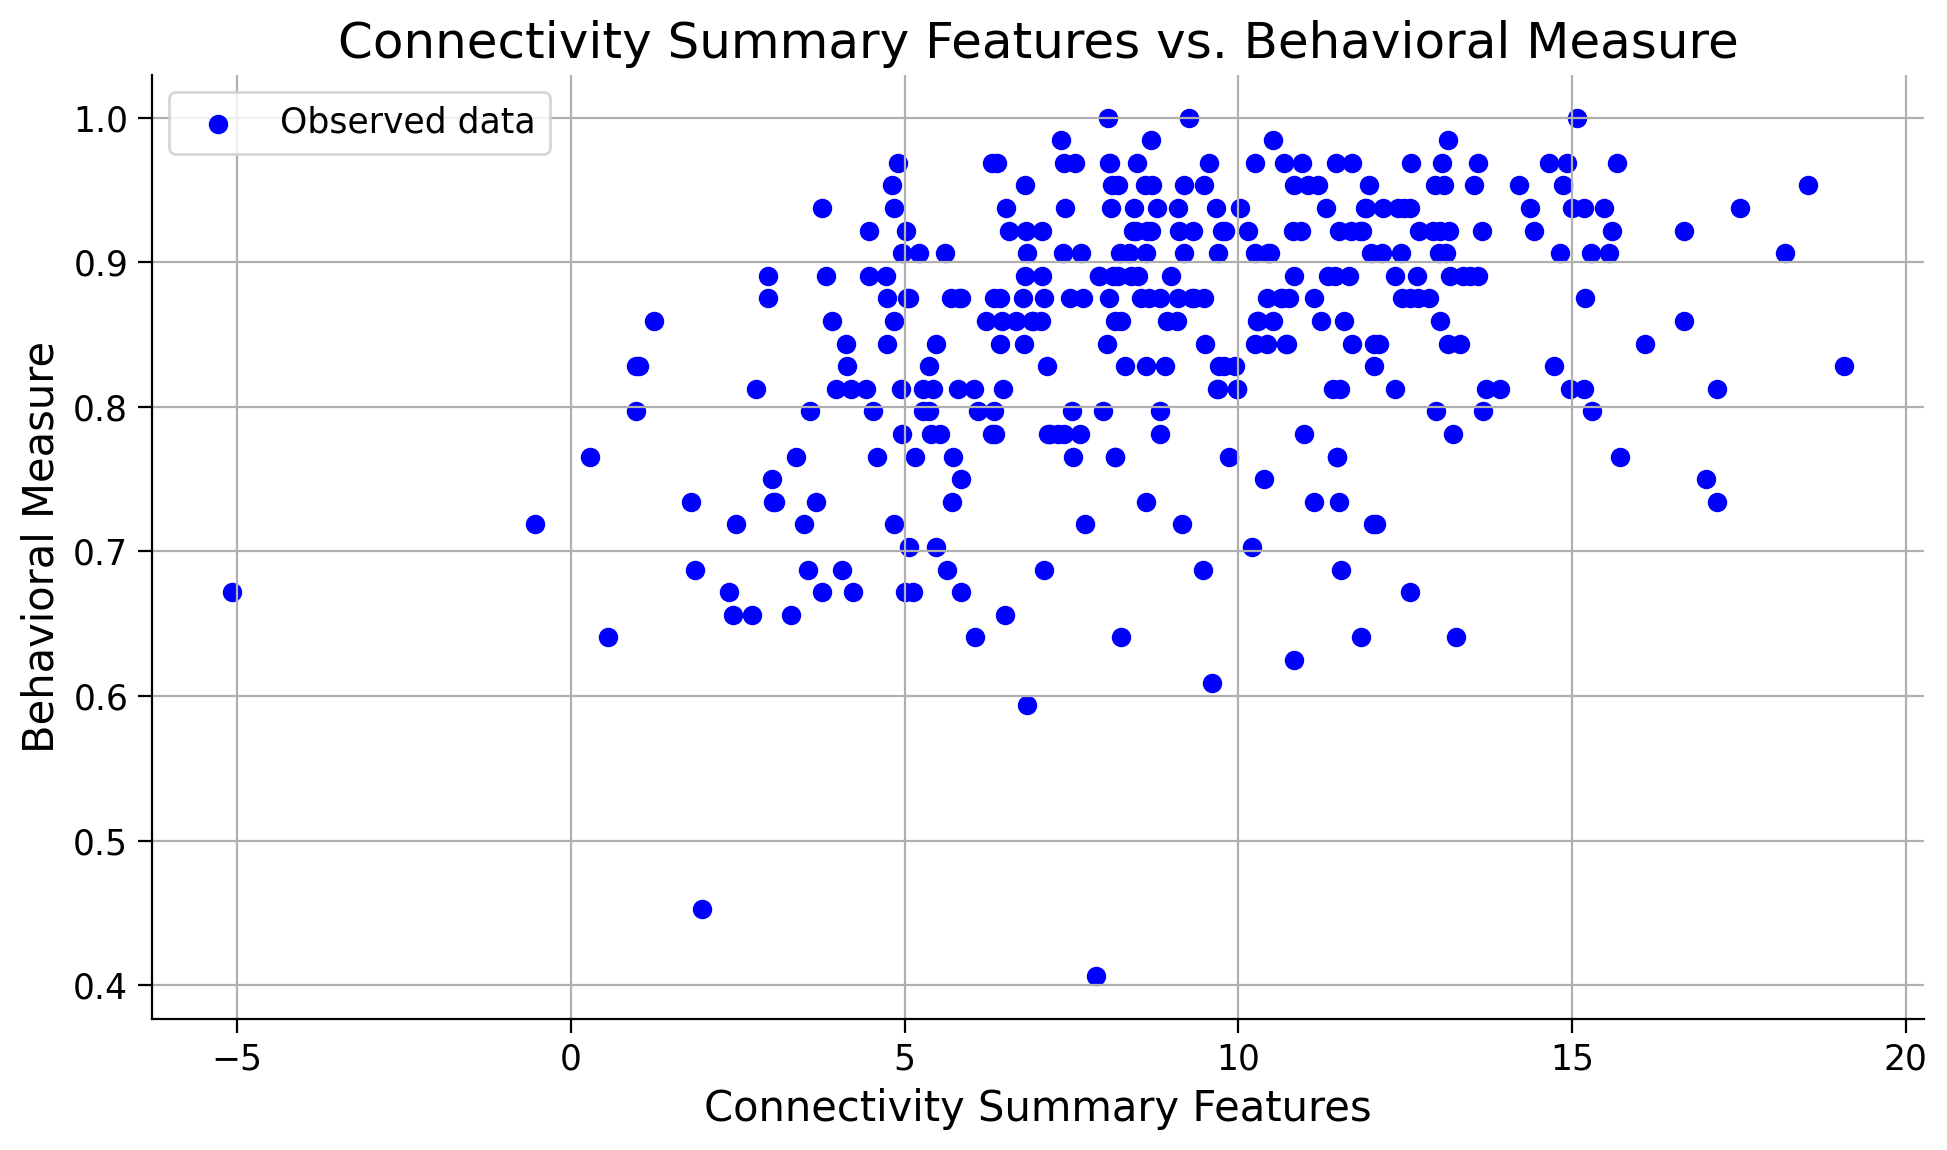

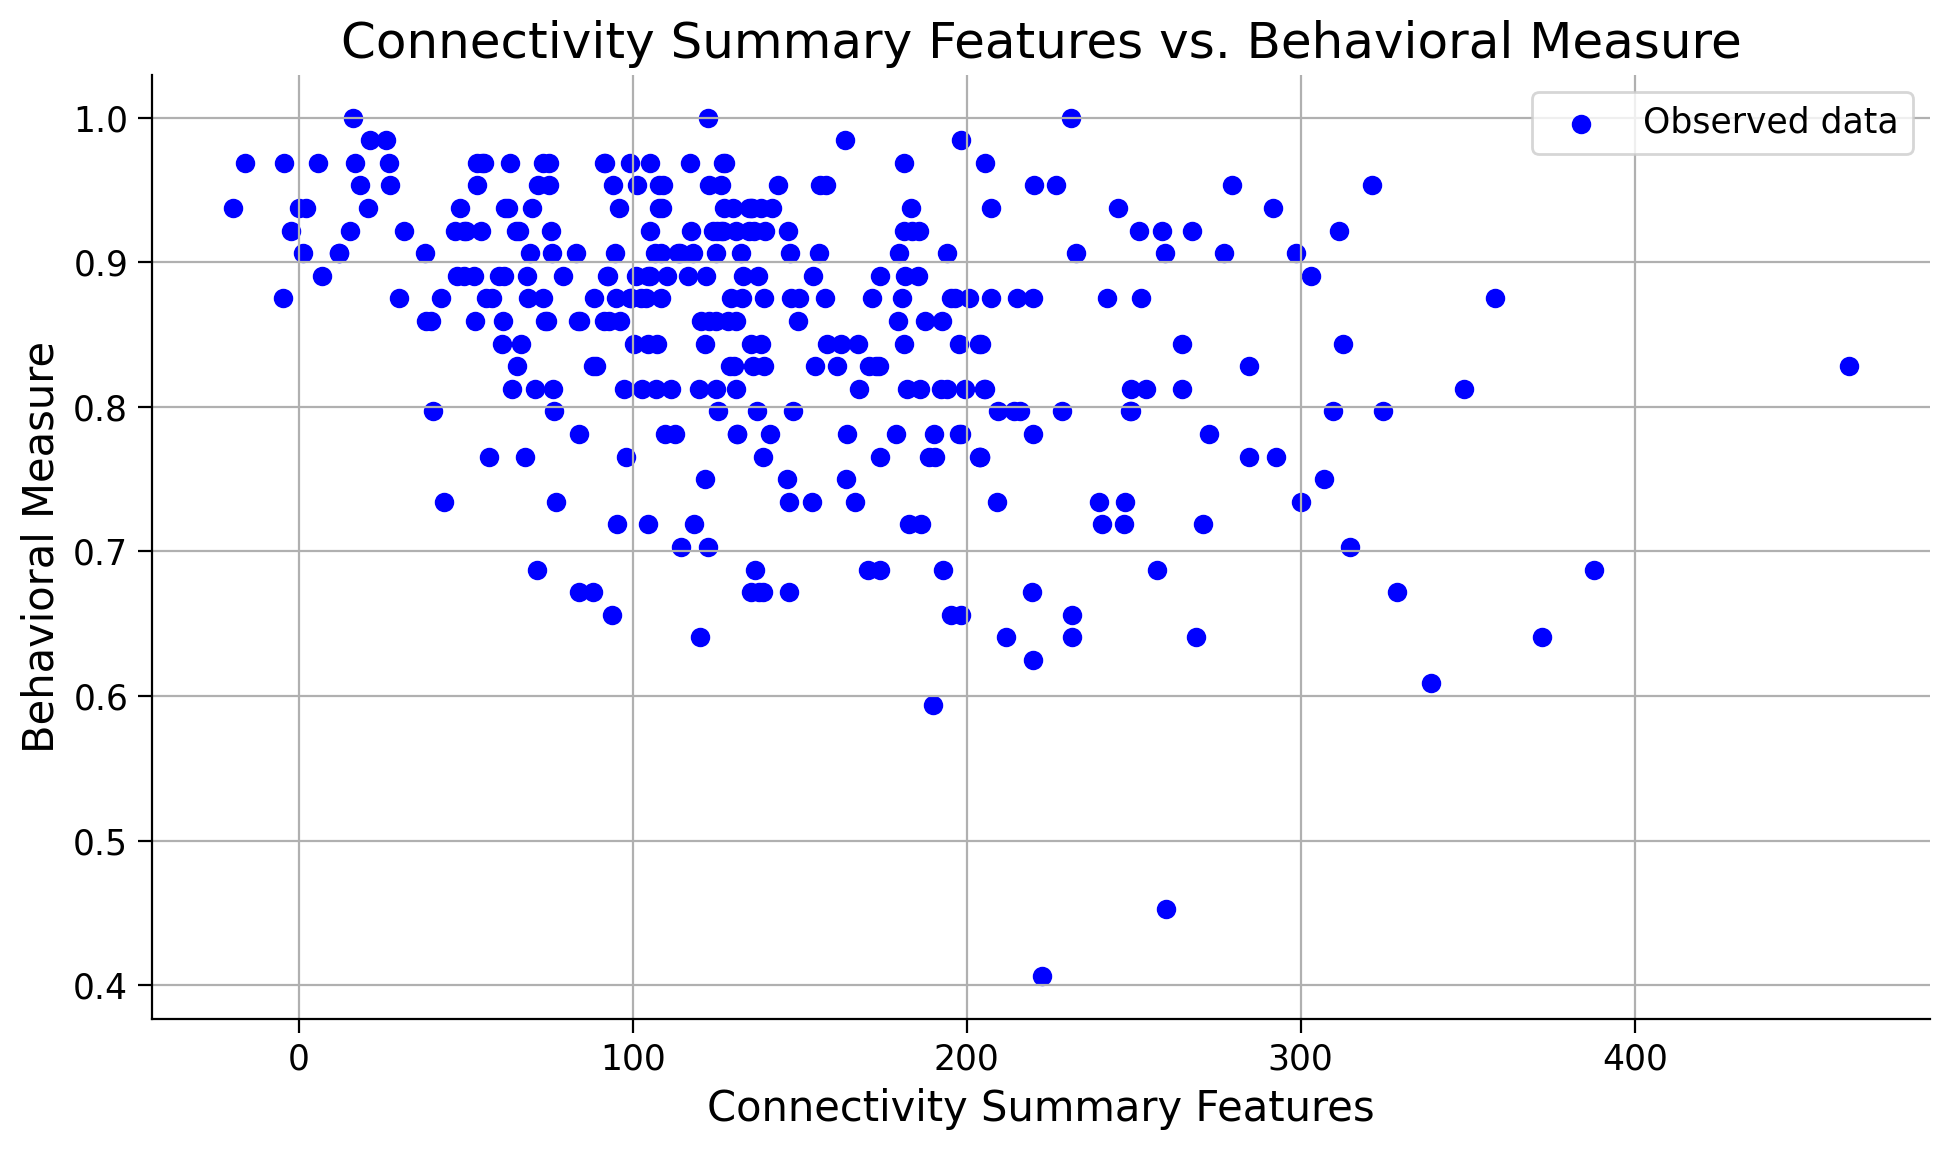

In [62]:
plot_connectivity_vs_behavior(X_summary_positive, y)
plot_connectivity_vs_behavior(X_summary_negative, y)